## Multi-asset derivative pricing: Monte Carlo simulation vs Closed form solution

Disclaimer: 
<br> This solution is showcased to share my understanding of the problem and my own approach to it.
<br> This solution is not intended for any general application.

#### For questions, suggestions and further details, please feel free to contact me at juan-carlos.ramirez@warwick.ac.uk

---------

### The problem

Find an analytical expression for the following derivative using the change of measure technique

$$ V(t_{0}, S_{1}, S_{2}) = M(t_0) \mathbb{E}^{Q}[\frac{1}{M(T)}S_{1}(T)\mathbf{1}_{\{S_{2}(T)>K\}}|\mathscr{F}_{t_0}] $$

for some $K \ge 0$. 

After finding the analytical expression, compute the value of the derivative using Monte Carlo simulation and the found expression and compare the results and the simulation convergence.

---- 
### The solution

In [1]:
import enum
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

sns.set_theme()
plt.rcParams['figure.figsize'] = [10, 5]

Start by using the following Radon-Nikodym density

$$ \frac{ d\mathbb{Q}^{S_1} }{ d\mathbb{Q} }|_{\mathscr{F}_{T}} = \frac{ S_{1}(T) M(t_0) }{ S_{1}(t_0) M(T) }$$

We can simplify the price of our contingent claim as shown next

$$ V(t_0) = M(t_0) \mathbb{E}^{Q}[\frac{1}{M(T)}S_{1}(T)\mathbf{1}_{\{S_{2}(T)>K\}}|\mathscr{F}_{t_0}] = 
S_{1}(t_{0}) \mathbb{Q}^{S_{1}}(S_{2}(T)>K)$$

And, our change of numeraire implies that the dynamics of $S_{2}$ now are

$$ \frac{dS_{2}(t)}{S_{2}(t)} = (r+\rho\sigma_{1}\sigma_{2})dt + \sigma_{2}dW_{2}^{S_1}(t) $$

Which in turn implies

$$ S_{2}(t) = S_{2}(t_0) \xi((r+\rho\sigma_{1}\sigma_{2})dt + \sigma_{2}dW_{2}^{S_1}(t)) $$

With the solution given by

$$  S_{2}(T) = S_{2}(t_{0}) exp[(r+\rho\sigma_{1}\sigma_{2}-\frac{ \sigma_{2}^{2} }{ 2 })(T-t_{0}) + \sigma_{2}(W_{2}^{S_2}(T) - W_{1}^{S_1}(t_{0})] $$

Where:
- $ \xi(.) $ = Stochastic Exponential

We can see that this solution for $S_{2}(t)$ implies that our prospective solution is very similar to the Black-Scholes model, with the difference of having the extra term $\rho\sigma_{1}\sigma_{2}$.

Letting $t_{0} = 0$ (Inception price), we get

$$ V(0) = S_{1}(0) \mathbb{Q}^{S_{1}}(S_{2}(T)>K) $$

$$ S_{2}(T) = S_{2}(0) \large{ e^{(r+\rho\sigma_{1}\sigma_{2}-\frac{ \sigma_{2}^{2} }{ 2 })T + \sigma_{2}W_{2}^{S_{1}}(T)} } $$

-----

First, implement the analytical price of our contingent claim as (proof is shown in HW Annex 1.pdf, exhibit 1.)

$$ V(0) = S_{1}(0)(1 - \phi(d)) $$

$$ d = -\frac{ Ln(\frac{ S_{2}(0) }{ K }) + (r + \rho\sigma_{1}\sigma_{2} - \frac{ \sigma_{2}^{2} }{ 2 })T }{ \sigma_{2}\sqrt{T} } $$

Where
- $\phi(.)$ represents the CDF of a standard normal distribution

In [2]:
# First, we implement the analytical solution
def AnalyticalPrice(T, S1, S2, K, r, sigma1, sigma2, rho):
    d = - ( np.log(S2/K) + (r + rho*sigma1*sigma2 - 0.5*(sigma2**2))*T ) / ( sigma2*np.sqrt(T) )
    return S1 * (1 - st.norm.cdf(d))

---
Next, we implement two Monte Carlo methods, Naive and Naive with Antihetic Variates (Variance reduction) to simulate paths for the correlated brownian motions. We are given that the dynamics for the asset $S_{m}(t)$ is the Geometric Brownian Motion given by:

$$ \frac{dS_m(t)}{S_m(t)} = rdt + \sigma_{m}dW_{m}(t) $$

which in turn implies

$$ S_m(t) = S_m(0)\xi(rdt + \sigma_{m}dW_{m}(t)) = S_m(0)\Large{ e^{( r-\frac{ \sigma_{m}^{2} }{2} )t + \sigma_{m}W_{m}(t)} } $$

For our simulation, we will use

$$ R_{m}(t) = ( r-\frac{ \sigma_{m}^{2} }{2} )t + \sigma_{m}W_{m}(t) $$

Where:
- $r$ risk free rate common among assets in this market.
- $\sigma_{m}$ is a vector of constant volatilities particular to every underlying asset.
- $W_{m}$ is the Wiener process, which is correlated with the other $W_{n}$ processes, with $n\ne m$

In [3]:
# NOTE: We only need the 2nd function, since the Naive dynamics can be recovered from it (Just use the Up simulations)

# Euler FTS Monte Carlo for an N-dimensional brownian motion (In this notebook, we work with 2-dimensional)
def NDim_Naive_MonteCarlo(S0,T,r,rho,vol,Npaths):
    Nbasket = len(S0)
    Nsteps = int(252 * T) # simulating every business day
    R = np.zeros((Nbasket, Npaths, Nsteps+1))
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    Sigma = np.diag(vol)@rho@np.diag(vol)
    L = cholesky(Sigma, lower=True) # Crucial, this was also suggested by the video lecture (Dimension reduction part)
    for n in range(Nsteps):
        X = np.random.normal(0,1,(Nbasket, Npaths))
        dW = L @ X
        for m in range(Nbasket):
            if n == 0:
                R[m,:,n] = np.log(S0[m])
            R[m,:,n+1] = R[m,:,n] + (r - 0.5 * vol[m] ** 2.0) * dt + np.sqrt(dt) * dW[m,:]
    S = np.exp(R)
    return t, S

# Euler FTS Antihetic Variates Monte Carlo for an N-dimensional brownian motion (In this notebook, we work with 2-dimensional)
def NDim_AV_MonteCarlo(S0,T,r,rho,vol,Npaths):
    Nbasket = len(S0)
    Nsteps = int(252 * T) # simulating every business day
    Ru = np.zeros((Nbasket, Npaths, Nsteps+1))
    Rd = np.zeros((Nbasket, Npaths, Nsteps+1))
    t, dt = np.linspace(0, T, Nsteps + 1, retstep=True)
    Sigma = np.diag(vol)@rho@np.diag(vol)
    L = cholesky(Sigma, lower=True) # Crucial, this was also suggested by the video lecture (Dimension reduction part)
    for n in range(Nsteps):
        X = np.random.normal(0,1,(Nbasket, Npaths))
        dW = L @ X
        for m in range(Nbasket):
            if n == 0:
                Ru[m,:,n] = np.log(S0[m])
                Rd[m,:,n] = np.log(S0[m])
            Ru[m,:,n+1] = Ru[m,:,n] + (r - 0.5 * vol[m] ** 2.0) * dt + np.sqrt(dt) * dW[m,:]
            Rd[m,:,n+1] = Rd[m,:,n] + (r - 0.5 * vol[m] ** 2.0) * dt - np.sqrt(dt) * dW[m,:]
    Su = np.exp(Ru)
    Sd = np.exp(Rd)
    return t, Su, Sd

----
Now, we implement the basic contingent claims pricing formula on our pay-off function 

$$ V(0) = \mathbb{E}^{Q}[\frac{1}{M(T)}S_{1}(T)\mathbf{1}_{\{S_{2}(T)>K\}}|\mathscr{F}_{0}] $$

Where
- $M(T)$ is a non-stochastic bank account


In [4]:
# Our contingent claim discounted payoff function using Naive Monte Carlo
def CC_Payoff_Naive(S, K, r, T):
    fB = np.exp(-r * T) * ( S[0,:,-1] * (S[1,:,-1] > K) ) # Discounted Pay-Off
    return np.mean(fB), np.sqrt(np.var(fB)/len(fB)) # Monte Carlo Stats

# Our contingent claim discounted payoff function using AV Monte Carlo
def CC_Payoff_AV(Su, Sd, K, r, T):
    fBu = np.exp(-r * T) * ( Su[0,:,-1] * (Su[1,:,-1] > K) )
    fBd = np.exp(-r * T) * ( Sd[0,:,-1] * (Sd[1,:,-1] > K) ) 
    fB = (fBu + fBd) / 2 # Centered path
    return np.mean(fB), np.sqrt(np.var(fB)/len(fB)) # Monte Carlo Stats

---
Finally, we check the convergence of our methods

In [9]:
# Input parameters
T = 5
S1 = 1
S2 = 2
K = 2.5
r = 0.05
rho = 0.7
sigma1 = 0.1
sigma2 = 0.2
Npaths = 2500
ConvergenceTests = 50
S0, vol, Rho = np.array([S1, S2]), np.array([sigma1, sigma2]), np.array([[1.0,rho],[rho,1.0]])

print("Results using ", str(Npaths), " simulations:")
# Analytical Price
V = AnalyticalPrice(T, S1, S2, K, r, sigma1, sigma2, rho)
print("Analytical Price = ", round(V,4))
# Monte Carlo Simulation
t, Su, Sd = NDim_AV_MonteCarlo(S0, T, r, Rho, vol, Npaths)
V, V_CI = CC_Payoff_Naive(Su, K, r, T)
print("Naive Monte Carlo price = ", round(V,4), "+/-", format(1.96*V_CI,'.2g'))
V, V_CI = CC_Payoff_AV(Su, Sd, K, r, T)
print("Antihetic Variates Monte Carlo price = ", round(V,4), "+/-", format(1.96*V_CI,'.2g'))

Results using  2500  simulations:
Analytical Price =  0.9771
Naive Monte Carlo price =  0.9731 +/- 0.011
Antihetic Variates Monte Carlo price =  0.9758 +/- 0.0034


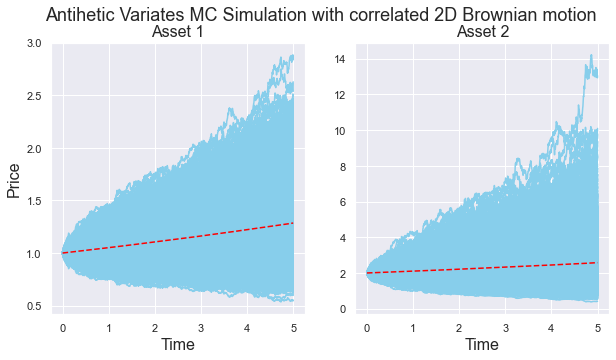

In [6]:
S = (Su + Sd)/2
fig = plt.figure()
fig.suptitle('Antihetic Variates MC Simulation with correlated 2D Brownian motion',fontsize=18)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.set_title('Asset 1',fontsize=16)
ax1.plot(t, np.transpose(Su[0,:,:]), 'skyblue')
ax1.plot(t, np.transpose(Sd[0,:,:]), 'skyblue')
ax1.plot(t, np.transpose(S[0,:,:]).mean(axis=1), '--', color='red')
ax1.set_ylabel("Price", fontsize=16)
ax1.set_xlabel("Time", fontsize=16)

ax2.set_title('Asset 2',fontsize=16)
ax2.plot(t, np.transpose(Su[1,:,:]), 'skyblue')
ax2.plot(t, np.transpose(Sd[1,:,:]), 'skyblue')
ax2.plot(t, np.transpose(S[1,:,:]).mean(axis=1), '--', color='red')
ax2.set_xlabel("Time", fontsize=16)

plt.subplots_adjust(hspace=0.01)
ax2.autoscale()
plt.show()

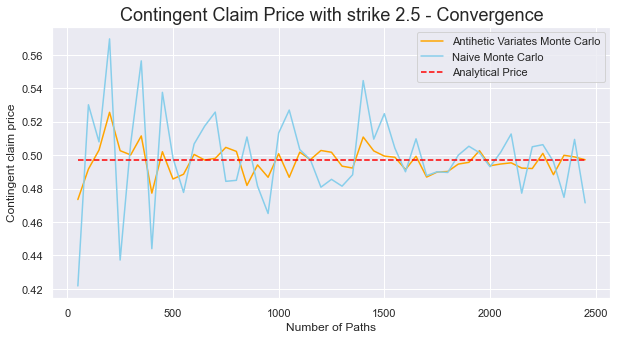

In [7]:
Grid = range(Npaths//ConvergenceTests, Npaths, Npaths//ConvergenceTests)
Runs = len(Grid)

resultMC_Naive = np.zeros([Runs])
resultMC_AV = np.zeros([Runs])
resultAnal = np.zeros([Runs])

for (i,N) in enumerate(Grid):
    t, Su, Sd = NDim_AV_MonteCarlo(S0, T, r, Rho, vol, N)
    resultMC_AV[i] = CC_Payoff_AV(Su, Sd, K, r, T)[0]
    resultMC_Naive[i] = CC_Payoff_Naive(Su, K, r, T)[0]
    resultAnal[i] = AnalyticalPrice(T, S1, S2, K, r, sigma1, sigma2, rho)
    
plt.plot(Grid,resultMC_AV, 'orange')
plt.plot(Grid,resultMC_Naive, 'skyblue')
plt.plot(Grid,resultAnal,'--',color='red')
plt.title('Contingent Claim Price with strike ' + str(round(K,1)) + ' - Convergence',fontsize=18)
plt.xlabel('Number of Paths')
plt.ylabel('Contingent claim price')
plt.legend(['Antihetic Variates Monte Carlo','Naive Monte Carlo','Analytical Price'])
plt.show()

------
## References
[1] Financial Engineering Course
<br> Lecture 2 https://www.youtube.com/watch?v=Xta1_F49noA&list=PL6zzGYGhbWrMpjEKDtnrHWyIj-oVLKCYD&index=4